In [1]:
import string
import re
import warnings
import requests
from multiprocess import Process, Manager
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

pd.options.display.max_columns = None
pd.set_option('max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/wordcloud/wordcloud.py:35: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))


In [2]:
articles = pd.read_csv(
    './data/rwe_news_prep.csv', 
    delimiter=';'
)
articles = articles.sample(
    frac=1
).reset_index(drop=True)#.head(1000)

articles = articles.dropna(
    subset=['time_stamp', 'title']
)

# clip news on weekend to friday
articles['time_stamp'] = pd.to_datetime(articles['time_stamp'])
articles['time_stamp'] -= pd.to_timedelta((articles['time_stamp'].dt.dayofweek - 4).clip(lower=0), unit='D')

In [3]:
punctuation = string.punctuation
punctuation += '•€'

stop_words = stopwords.words('english')

lemmatizer = WordNetLemmatizer()

def map_postag(word):
    if word == 'NOUN':
        return 'n'
    elif word == 'VERB':
        return 'v'
    elif word == 'ADJ':
        return 'a'
    elif word == 'ADV':
        return 'r'
    else:
        return 'n'

def preprocessor(X):
    # to lower
    X = X.lower()
    # punctuation
    X = X.translate(str.maketrans('', '', punctuation))
    # remove multi white space
    X = ' '.join(X.split())
    
    return X

def tokenizer(X):
    # tokenize
    X = word_tokenize(X, language='english')
    # pos tag
    X = pos_tag(X, tagset='universal')
    X = [(s[0], map_postag(s[1])) for s in X]
    # remove strange words
    q = [r'(.)\1\1', r'\d', 'www', 'http']
    X = [s for s in X if not any([bool(re.search(x, s[0])) for x in q])]
    X = [s for s in X if len(s[0]) < 20]
    # stopwords
    X = [s for s in X if len(s[0]) > 2]
    X = [s for s in X if not s[0] in stop_words]
    # lemmatize
    X = [lemmatizer.lemmatize(s[0], pos=s[1]) for s in X]
    
    return X

# Data Understanding

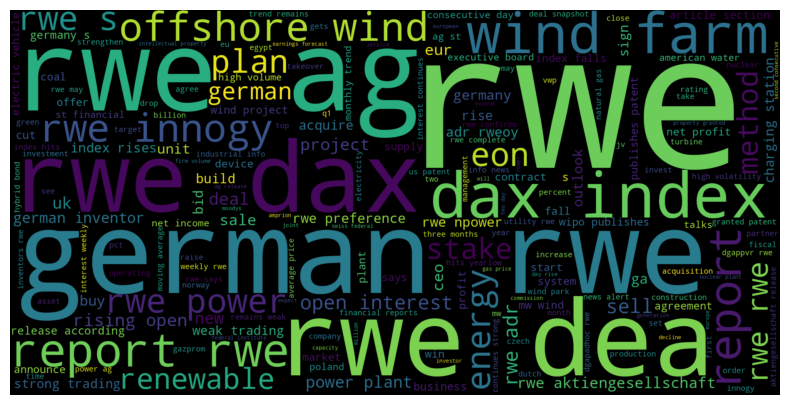

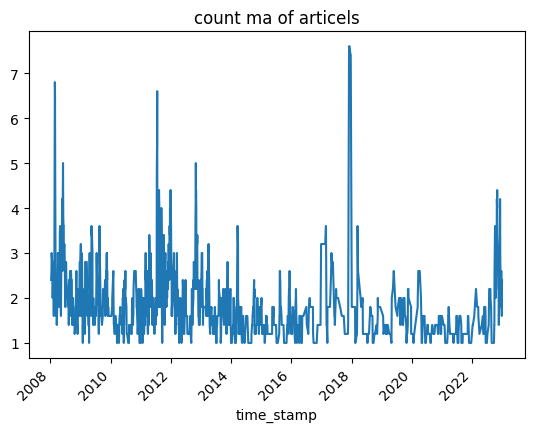

In [4]:
articles_string = articles['title'].to_list()
articles_string = ' '.join(articles_string)
articles_string = articles_string.lower()
articles_string = articles_string.translate(str.maketrans('', '', punctuation))
articles_string = ' '.join(articles_string.split())

wordcloud = WordCloud(width=2000, height=1000)
wordcloud.generate(articles_string)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

articles.groupby('time_stamp').size().rolling(5).mean().plot(
    kind='line',
    title='count ma of articels'
)
plt.xticks(rotation = 45)
plt.show()

# Topic Modeling

In [5]:
def create_topic_activity(doc_topic: pd.DataFrame, docs: pd.DataFrame) -> pd.DataFrame:
    # insert time_stamp
    doc_topic['time_stamp'] = pd.to_datetime(docs['time_stamp'])

    # sum up news by date and company
    doc_topic['time_stamp'] = doc_topic['time_stamp'].dt.date
    count = doc_topic.groupby('time_stamp').size() + 0.0001
    topic_activity = doc_topic.groupby(['time_stamp']).sum()
    #topic_activity = topic_activity.div(count, axis=0)
    topic_activity['count'] = count

    # insert 0 for days with no news
    topic_activity.index = pd.to_datetime(topic_activity.index)
    topic_activity = topic_activity.asfreq('D', fill_value=0)

    # drop weekends
    topic_activity = topic_activity[topic_activity.index.get_level_values('time_stamp').dayofweek < 5]

    # add random validation topic
    topic_activity['topic_val_1'] = np.random.uniform(
        topic_activity.min().min(), topic_activity.max().max(),
        size=len(topic_activity)
    )
    
    topic_activity['topic_val_2'] = np.random.normal(
        scale=0.02,
        size=len(topic_activity)
    ) * topic_activity.max().max()
    
    topic_activity['topic_val_2'] = abs(topic_activity['topic_val_2']).astype('int')
    

    # compute moving average
    #topic_activity = topic_activity.ewm(halflife=5).mean()
    
    topic_activity.plot(
        kind='line',
        title='Topic Activity',
        subplots=True,
        figsize=(15, 10)
    )
    plt.tight_layout()
    plt.show()
    
    return topic_activity

## LDA

In [6]:
from sklearn.decomposition import LatentDirichletAllocation
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


### Data preparation

In [7]:
%%time
lda_vectorizer = CountVectorizer(
    preprocessor=preprocessor,
    tokenizer=tokenizer,
    max_df=0.1,
    min_df=2,
    ngram_range=(1,2)
)

X = lda_vectorizer.fit_transform(articles['title'])
tokens = articles['title'].apply(lda_vectorizer.build_analyzer()).to_list()

print(f'n_articels: {X.shape[0]}')
print(f'n_features (words/ngrams): {X.shape[1]}')

n_articels: 3080
n_features (words/ngrams): 4672
CPU times: user 4.99 s, sys: 222 ms, total: 5.21 s
Wall time: 5.24 s


### Evaluation

In [8]:
%%time
def compute_coherence(topic_coherence, t):
    # train lda
    lda = LatentDirichletAllocation(
        n_components=t,
        doc_topic_prior=None,
        topic_word_prior=None,
        learning_method='online',
    )
    lda.fit(X)
    
    # compute coherence score
    coherence = metric_coherence_gensim(
        measure='c_v',
        top_n=10,
        topic_word_distrib=lda.components_,
        vocab=lda_vectorizer.get_feature_names_out(),
        dtm=X,
        texts=tokens,
        return_mean=True
    )
    
    # append to shared list
    topic_coherence.append([t, coherence])
"""
# test hyper params
with Manager() as manager:
    topic_coherence = manager.list()
    processes = []
    max_topics = 10
    for t in range(1, max_topics):
        p = Process(target=compute_coherence, args=(topic_coherence, t))
        p.start()
        processes.append(p)
    for p in processes:
        p.join()
        
    topic_coherence = list(topic_coherence)

topic_coherence = pd.DataFrame(data=topic_coherence, columns=['n_topics', 'coherence_score'])

topic_coherence.sort_values('n_topics').plot(x='n_topics', y='coherence_score', grid=True)
plt.show()
"""

CPU times: user 11 µs, sys: 1e+03 ns, total: 12 µs
Wall time: 14.8 µs


"\n# test hyper params\nwith Manager() as manager:\n    topic_coherence = manager.list()\n    processes = []\n    max_topics = 10\n    for t in range(1, max_topics):\n        p = Process(target=compute_coherence, args=(topic_coherence, t))\n        p.start()\n        processes.append(p)\n    for p in processes:\n        p.join()\n        \n    topic_coherence = list(topic_coherence)\n\ntopic_coherence = pd.DataFrame(data=topic_coherence, columns=['n_topics', 'coherence_score'])\n\ntopic_coherence.sort_values('n_topics').plot(x='n_topics', y='coherence_score', grid=True)\nplt.show()\n"

### Training

In [9]:
%%time
lda_model = LatentDirichletAllocation(
    n_components=5,
    doc_topic_prior=None,
    topic_word_prior=None,
    learning_method='online',
    random_state=42,
)
lda_model.fit(X)

CPU times: user 2.46 s, sys: 5.33 ms, total: 2.46 s
Wall time: 2.46 s


LatentDirichletAllocation(learning_method='online', n_components=5,
                          random_state=42)

### Results

In [10]:
#pyLDAvis.sklearn.prepare(lda_model, X, lda_vectorizer)

In [11]:
# prepare doc topic distribution
lda_doc_topic = lda_model.transform(X)
lda_doc_topic = pd.DataFrame(
    lda_doc_topic,
    columns=[f'topic_{i}' for i in range(1, lda_doc_topic.shape[1]+1)]
)

# calculate topic distribution
topic_size = (lda_doc_topic.sum() / len(lda_doc_topic)).to_frame().transpose()
display(topic_size)

# prepare topic word distribution
topic_word = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]
topic_word = pd.DataFrame(
    topic_word,
    index=[f'topic_{i}' for i in range(1, topic_word.shape[0]+1)],
    columns=lda_vectorizer.get_feature_names_out()
).round(5)

# display topics
for topic in topic_word.index:
    display(topic_word.sort_values(topic, axis=1, ascending=False).loc[[topic], :].iloc[:, :10])

topic_1   topic_2   topic_3   topic_4   topic_5
0  0.203967  0.267627  0.191168  0.172936  0.164301

dea  rwe dea      gas   patent   energy  charge     deal  \
topic_1  0.02205  0.02036  0.01264  0.01079  0.00804  0.0079  0.00734   

         acquire   method  complete  
topic_1  0.00701  0.00701   0.00672

wind    farm  wind farm    plant    power   innogy  offshore  \
topic_2  0.03259  0.0196    0.01869  0.01493  0.01488  0.01418   0.01221   

         offshore wind  rwe innogy  german rwe  
topic_2        0.01151      0.0115     0.00978

volume    index    rise      adr      day      dax  dax index  \
topic_3  0.01481  0.01317  0.0129  0.01287  0.01283  0.01179    0.01174   

         rwe dax  rwe adr     fall  
topic_3  0.01174   0.0117  0.01067

rise     open  interest      gas    index  trading      dax  \
topic_4  0.0193  0.01651   0.01392  0.01274  0.01231  0.01189  0.01174   

         rwe dax  dax index  open interest  
topic_4  0.01167    0.01167        0.01121

power   patent  rwe power  offshore      new   supply  earnings  \
topic_5  0.01372  0.00967    0.00888   0.00848  0.00829  0.00821   0.00807   

         financial    grant  grant patent  
topic_5    0.00803  0.00694        0.0067

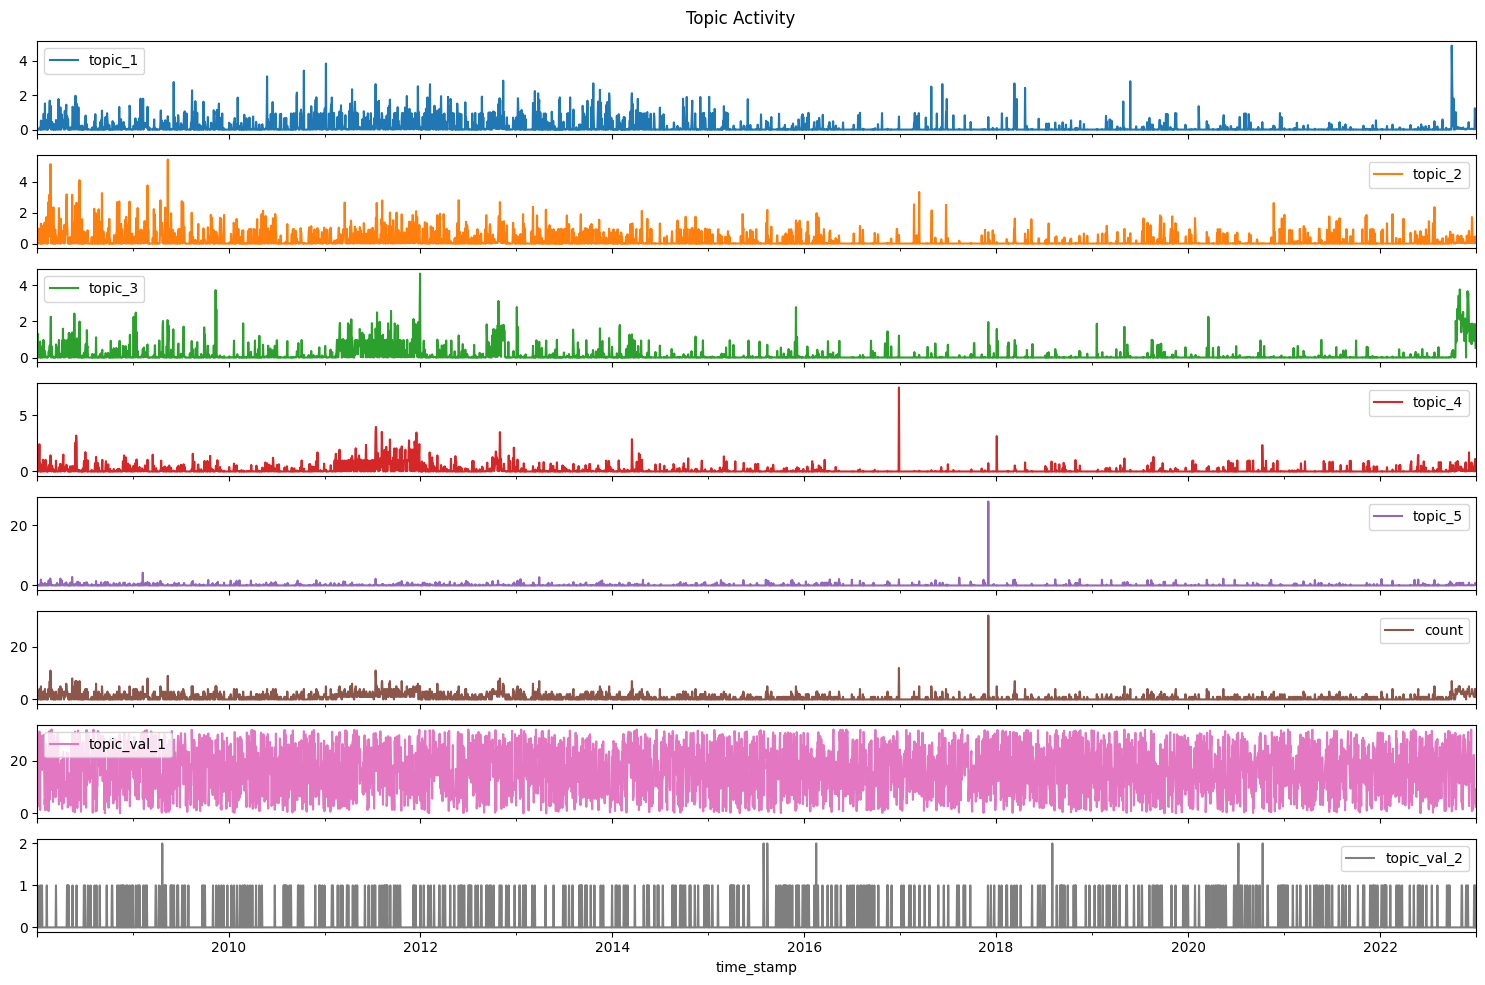

In [12]:
lda_topic_activity = create_topic_activity(lda_doc_topic, articles)

# safe to csv
lda_topic_activity.to_csv('data/rwe_lda_topic_activity.csv', sep=';')

## BERT Topic

In [13]:
from bertopic import BERTopic

2023-02-08 21:32:24.950906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/graph_objs/__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/graph_objs/__init__.py:288: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(ipywidgets.__version__) >= LooseVersion("7.0.0"):
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/graph_objs/__init__.py:288: DeprecationWarn

### Training

In [14]:
%%time
bert_vectorizer = CountVectorizer(
    preprocessor=preprocessor,
    tokenizer=tokenizer,
    ngram_range=(1,3)
)

bert_model = BERTopic(
    nr_topics=5,
    vectorizer_model=bert_vectorizer,
    language='english',
    calculate_probabilities=True,
    verbose=False
)

bert_model.fit(articles['title'])

topics, probs = bert_model.transform(articles['title'])
"""
topics = bert_model.reduce_outliers(
    articles['title'], topics,
    strategy='c-tf-idf',
    probabilities=probs,
    threshold=0
)
"""
"""
bert_doc_topic = pd.DataFrame(
    columns=[f'topic_{i}' for i in range(probs.shape[1])],
    data=probs,
).round(4)
bert_doc_topic['topic_-1'] = (1 - bert_doc_topic.sum(axis='columns')).clip(0, 1)
"""
bert_doc_topic = pd.DataFrame(
    columns=['topic'],
    data=topics,
    dtype='object'
)
bert_doc_topic = pd.get_dummies(bert_doc_topic)
bert_doc_topic.columns = bert_model.get_topic_info()['Name'].values

CPU times: user 2min 39s, sys: 7.58 s, total: 2min 46s
Wall time: 37 s


### Evaluation

Topic  Count                                Name
0     -1   1674          -1_rwe_german_report_power
1      0    415  0_rise_index_rwe dax index_rwe dax
2      1    331             1_rwe_profit_net_report
3      2    331           2_wind_farm_wind farm_rwe
4      3    177               3_dea_rwe dea_rwe_gas
5      4    152   4_patent_method_patent rwe_charge

remaining outliers: 1674


/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/figure_factory/_dendrogram.py:350: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  icoord = scp.array(P["icoord"])
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/figure_factory/_dendrogram.py:351: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  dcoord = scp.array(P["dcoord"])
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/figure_factory/_dendrogram.py:352: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  ordered_labels = scp.array(P["ivl"])
/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/figure_factory/_dendrogram.py:353: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  color_list 

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/tim/opt/anaconda3/envs/masterarbeit/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



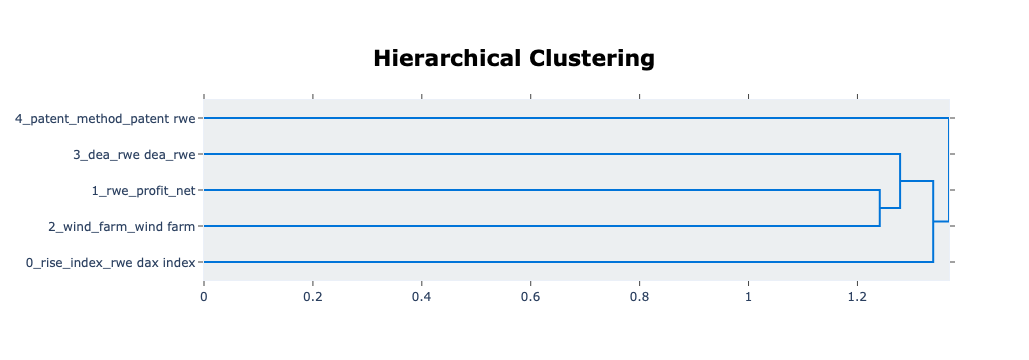

In [15]:
display(bert_model.get_topic_info())
print(f"remaining outliers: {bert_doc_topic.iloc[:, 0].sum()}")
bert_model.visualize_hierarchy()

### Results

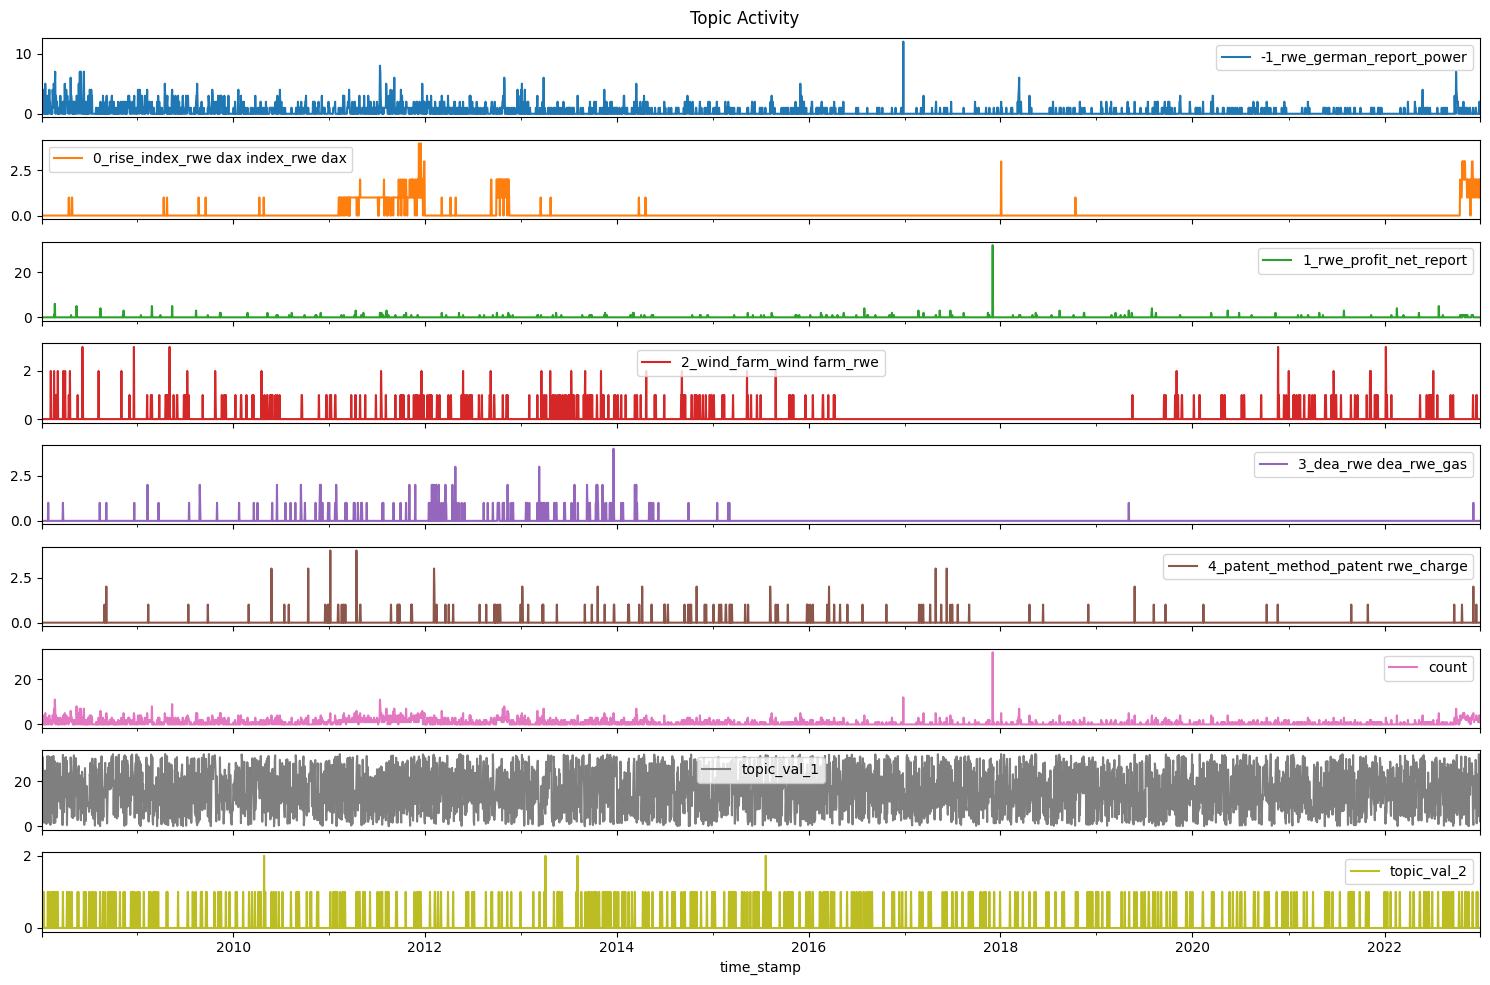

time_stamp  \
0    2008-04-04   
1    2022-12-01   
2    2008-09-15   
3    2018-04-27   
4    2011-07-25   
...         ...   
3075 2013-10-21   
3076 2013-07-24   
3077 2012-03-07   
3078 2009-08-18   
3079 2014-09-05   

                                                                                   title  \
0     E.ON, RWE , Vattenfall Europe , EnBW under investigation for overcharging - report   
1           Thursday December 01, 2022 RWE ADR Compendium - A Snapshot as of December 01   
2                                              German RWE Restructuring Delayed - Report   
3                    RWE reaffirms commitment to E.ON asset swap amid Macquarie interest   
4                   UK Department of Energy approves plan for RWE Dea's Breagh gas field   
...                                                                                  ...   
3075                      EANS-News: Semperit Group : Large RWE order for conveyor belts   
3076        GDF SUEZ and RWE complete installation of platform to develop Orca gas field   
3077              Analyst Actions: RWE AG Downgraded to Underweight from Neutral at HSBC   
3078     Treasury short-lists Germany 's RWE for talks on power firm Enea privatisation.   
3079                       RWE opens service base for 295- MW wind farm in German waters   

      topic  
0        -1  
1         0  
2        -1  
3        -1  
4         3  
...     ...  
3075      4  
3076      3  
3077     -1  
3078     -1  
3079      2  

[3080 rows x 3 columns]

In [16]:
# Topic activity for Baseline
bert_topic_activity = create_topic_activity(bert_doc_topic, articles)
#bert_topic_activity = bert_topic_activity[bert_topic_activity.index < '2016-01-01']

# safe to csv
bert_topic_activity.to_csv('data/rwe_bert_topic_activity.csv', sep=';')

# Dataset for Advanced Approach
dataset = articles.copy()
dataset['topic'] = topics
dataset.to_csv('data/rwe_news_dataset.csv', sep=';', index=False)

display(dataset)

In [17]:
display(dict(sorted(bert_model.get_representative_docs().items())))

{0: ['Thursday December 22, 2022 RWE ADR Compendium - A Snapshot as of December 22',
  'Thursday December 01, 2022 RWE ADR Compendium - A Snapshot as of December 01',
  'Thursday December 15, 2022 RWE ADR Compendium - A Snapshot as of December 15',
  'RWE preference decreases 1.3% on low volume',
  'RWE strengthens on weak volume',
  'RWE falls on low volume',
  'RWE [ DAX index] closes at 4.1% above VWP',
  'RWE [ DAX index] closes at 3.1% below VWP but at 38.2% premium to 52-week low',
  'RWE [ DAX index] closes at 5.4% above VWP but at 45.2% discount to 52-week high',
  'RWE ADR (RWEOY: $41.22) accelerates rise, up 6.1% in 2 days; +$1.81 [4.6%]',
  'RWE ADR (RWEOY: $38.10) in 2nd consecutive rise; +5c [0.1%] Vol Index 1.4 [1 is avg]',
  'Weekly: RWE ADR (RWEOY: $44.08) increases on weak volume; +4c [0.1%]',
  'RWE [Energy] falls in weak trading with rising open interest, monthly trend remains weak',
  'Weekly: RWE rises in strong trading with rising open interest, continues strong m

In [18]:
view = articles[articles['time_stamp'].between('2016-01-01', '2019-01-01')].sort_values('time_stamp')
display(view)

time_stamp  \
804  2016-01-07   
1231 2016-01-07   
1941 2016-01-11   
1238 2016-01-13   
1308 2016-01-13   
...         ...   
1627 2018-11-15   
2383 2018-11-15   
699  2018-11-16   
64   2018-11-30   
2364 2018-12-13   

                                                                                                                                                                                                                         title  
804                                                                                                                                                        RWE AG - Power Plants and SWOT Analysis, 2015: Acute Market Reports  
1231  Swiss Federal Institute of Intellectual Property granted patent to RWE Power Aktiengesellschaft on January 6, 2016 titled as "Sorbent for dry cleaning of waste gases loaded with mercury and method for its production"  
1941                                                                                                                                                                RWE sells UK power station intended for biomass conversion  
1238                                                                                                                                                                         -Hildegard Muller to join RWE Group on 1 May 2016  
1308                                                                                                                                                             Germany 's RWE to jump into large solar segment, bid in Dubai  
...                                                                                                                                                                                                                        ...  
1627                                                                                                                                                   RWE 's business performs as planned in the first three quarters of 2018  
2383                                                                  Clean Fine Coal Market Future Growth Witnessing High Demand by 2018-2025 by top key Players : Peabody, Arch Coal, Anglo American , RWE AG , BHP Billiton  
699                                                                                                                                                              E.ON, RWE on track to complete blockbuster asset swap in 2019  
64                                                                                                          Australia: RWE Power Receives Patent for 'Method and system for gas scrubbing of aerosol-containing process gases'  
2364                                                                                                                                        -RWE Supervisory Board extends contract with Executive Board member Markus Krebber  

[277 rows x 2 columns]